In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:

def create_frequency_grid(size):
    """Create a 2D frequency grid centered at (size//2, size//2)."""
    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    X, Y = np.meshgrid(x, y)
    D = np.sqrt(X**2 + Y**2)
    return D, X, Y

def create_1d_profile(size):
    """Create 1D frequency profile."""
    return np.linspace(0, size//2, size//2)

def ideal_bandstop(D, C0, W):
    """Ideal bandstop filter response.
    C0: Center frequency
    W: Bandwidth
    """
    D0_low = C0 - W/2
    D0_high = C0 + W/2
    return np.logical_or(D <= D0_low, D >= D0_high).astype(float)

def butterworth_bandstop(D, C0, W, n):
    """Butterworth bandstop filter response.
    C0: Center frequency
    W: Bandwidth
    n: Order of filter
    """
    H = 1 / (1 + ((D * W) / (D**2 - C0**2))**(2 * n))
    return np.nan_to_num(H, nan=0.0)

def gaussian_bandstop(D, C0, W):
    """Gaussian bandstop filter response.
    C0: Center frequency
    W: Bandwidth
    """
    H = 1 - np.exp(-((D**2 - C0**2) / (D * W))**2)
    return np.nan_to_num(H, nan=1.0)

def plot_comprehensive_view(C0, W, n_butterworth, filter_type='All'):
    """Create comprehensive visualization with 1D, 3D and magnitude plots."""
    size = 100
    D_2d, X, Y = create_frequency_grid(size)
    D_1d = create_1d_profile(size)

    filters = {}
    if filter_type in ['All', 'Ideal']:
        filters['Ideal'] = ideal_bandstop(D_2d, C0, W)
    if filter_type in ['All', 'Butterworth']:
        filters['Butterworth'] = butterworth_bandstop(D_2d, C0, W, n_butterworth)
    if filter_type in ['All', 'Gaussian']:
        filters['Gaussian'] = gaussian_bandstop(D_2d, C0, W)

    # Theoretical cutoff frequencies
    D0_low = C0 - W/2
    D0_high = C0 + W/2

    n_filters = len(filters)
    fig = plt.figure(figsize=(5*n_filters, 12))

    for idx, (name, response) in enumerate(filters.items()):
        # 1D Profile
        ax1 = fig.add_subplot(3, n_filters, idx + 1)
        ax1.plot(D_1d, response[size//2, size//2:], linewidth=2)
        ax1.axvline(x=D0_low, color='r', linestyle='--', alpha=0.5, label='Lower cutoff')
        ax1.axvline(x=D0_high, color='r', linestyle='--', alpha=0.5, label='Upper cutoff')
        ax1.axvline(x=C0, color='g', linestyle='--', alpha=0.5, label='Center freq')
        ax1.set_title(f'{name} Bandstop Filter 1D Profile\nC₀={C0}, W={W}')
        ax1.set_xlabel('Frequency')
        ax1.set_ylabel('Response')
        ax1.grid(True)
        ax1.legend()

        # 3D Surface
        ax2 = fig.add_subplot(3, n_filters, idx + 1 + n_filters, projection='3d')
        surf = ax2.plot_surface(X, Y, response, cmap='viridis')
        ax2.set_title(f'{name} Bandstop Filter 3D Surface')
        ax2.set_xlabel('u')
        ax2.set_ylabel('v')
        ax2.set_zlabel('H(u,v)')

        # Magnitude Image
        ax3 = fig.add_subplot(3, n_filters, idx + 1 + 2*n_filters)
        im = ax3.imshow(response, cmap='viridis')
        ax3.set_title(f'{name} Bandstop Filter Magnitude')
        plt.colorbar(im, ax=ax3)

        # Draw center frequency and bandwidth circles
        circle_c0 = plt.Circle((size//2, size//2), C0,
                             color='g', fill=False, linestyle='--', alpha=0.5)
        circle_low = plt.Circle((size//2, size//2), D0_low,
                              color='r', fill=False, linestyle='--', alpha=0.5)
        circle_high = plt.Circle((size//2, size//2), D0_high,
                               color='r', fill=False, linestyle='--', alpha=0.5)
        ax3.add_artist(circle_c0)
        ax3.add_artist(circle_low)
        ax3.add_artist(circle_high)

    plt.tight_layout()
    plt.show()

def apply_bandstop_filter(img, C0, W, n_butterworth):
    """Apply all bandstop filters to an image."""
    if len(img.shape) > 2:
        img = np.mean(img, axis=2)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)

    rows, cols = img.shape
    D, _, _ = create_frequency_grid(rows)

    filters = {
        'Ideal': ideal_bandstop(D, C0, W),
        'Butterworth': butterworth_bandstop(D, C0, W, n_butterworth),
        'Gaussian': gaussian_bandstop(D, C0, W)
    }

    filtered_images = {}
    filtered_spectrums = {}

    for name, filt in filters.items():
        filtered_shift = fshift * filt
        filtered_images[name] = np.real(np.fft.ifft2(np.fft.ifftshift(filtered_shift)))
        filtered_spectrums[name] = np.log(np.abs(filtered_shift) + 1)

    # Plot results with center frequency and bandwidth visualization
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))

    # Original image and spectrum
    axes[0,0].imshow(img, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[1,0].imshow(magnitude_spectrum, cmap='gray')
    axes[1,0].set_title('Original Spectrum')
    axes[2,0].remove()

    # Draw center frequency and bandwidth circles on spectrum
    circle_c0 = plt.Circle((rows//2, cols//2), C0,
                          color='g', fill=False, linestyle='--', alpha=0.5)
    circle_low = plt.Circle((rows//2, cols//2), C0-W/2,
                          color='r', fill=False, linestyle='--', alpha=0.5)
    circle_high = plt.Circle((rows//2, cols//2), C0+W/2,
                           color='r', fill=False, linestyle='--', alpha=0.5)
    axes[1,0].add_artist(circle_c0)
    axes[1,0].add_artist(circle_low)
    axes[1,0].add_artist(circle_high)

    # Filtered images and spectrums
    for idx, (name, filtered) in enumerate(filtered_images.items(), 1):
        # Filter response
        axes[0,idx].imshow(filters[name], cmap='viridis')
        axes[0,idx].set_title(f'{name} Filter')

        # Filtered image
        axes[1,idx].imshow(filtered_images[name], cmap='gray')
        axes[1,idx].set_title(f'{name} Filtered')

        # Filtered spectrum
        axes[2,idx].imshow(filtered_spectrums[name], cmap='gray')
        axes[2,idx].set_title(f'{name} Spectrum')

        # Add circles to spectrum plots
        circle_c0 = plt.Circle((rows//2, cols//2), C0,
                              color='g', fill=False, linestyle='--', alpha=0.5)
        circle_low = plt.Circle((rows//2, cols//2), C0-W/2,
                              color='r', fill=False, linestyle='--', alpha=0.5)
        circle_high = plt.Circle((rows//2, cols//2), C0+W/2,
                               color='r', fill=False, linestyle='--', alpha=0.5)
        axes[2,idx].add_artist(circle_c0)
        axes[2,idx].add_artist(circle_low)
        axes[2,idx].add_artist(circle_high)

    for ax in axes.flat:
        if ax is not None:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def create_test_images(size=256):
    """Create test images with multiple frequency components."""
    # Create coordinate grids
    x = np.linspace(-10, 10, size)
    y = np.linspace(-10, 10, size)
    X, Y = np.meshgrid(x, y)

    # Multi-frequency pattern
    # Low frequency component
    low_freq = np.sin(0.5*X) + np.sin(0.5*Y)
    # Mid frequency component
    mid_freq = 0.5 * (np.sin(2*X) + np.sin(2*Y))
    # High frequency component
    high_freq = 0.25 * (np.sin(5*X) + np.sin(5*Y))

    # Combined patterns
    multi_freq = low_freq + mid_freq + high_freq

    # Pattern with dominant mid frequencies
    mid_dominant = 0.2*low_freq + mid_freq + 0.2*high_freq

    # Radial frequency pattern
    R = np.sqrt(X**2 + Y**2)
    radial = (np.sin(R) + np.sin(2*R) + np.sin(4*R))/3

    return {
        'Multi-frequency': multi_freq,
        'Mid-Dominant': mid_dominant,
        'Radial': radial
    }



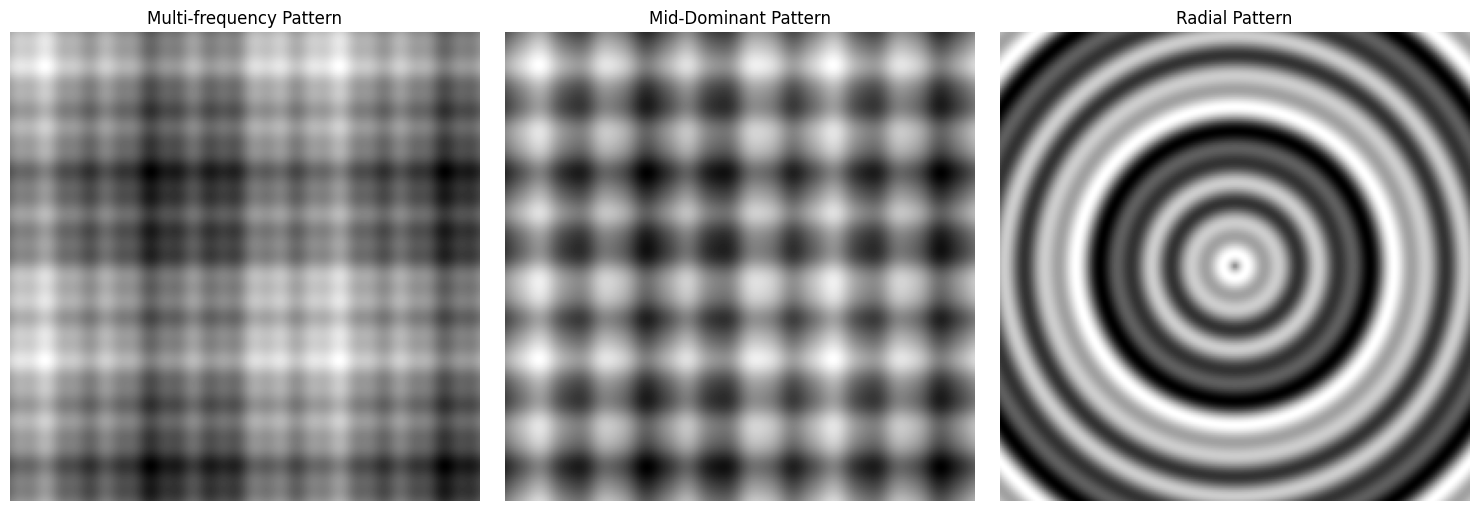

In [3]:
# Generate test images
test_images = create_test_images(256)

# Display all test images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (name, img) in enumerate(test_images.items()):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'{name} Pattern')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()



In [4]:
# Create interactive widgets
image_dropdown = widgets.Dropdown(
    options=test_images.keys(),
    description='Image:',
    value='Mid-Dominant'
)

# Show filter responses
interact(
    plot_comprehensive_view,
    C0=widgets.IntSlider(
        value=25,
        min=1,
        max=50,
        step=1,
        description='C₀:',
        continuous_update=False
    ),
    W=widgets.IntSlider(
        value=10,
        min=1,
        max=30,
        step=1,
        description='W:',
        continuous_update=False
    ),
    n_butterworth=widgets.IntSlider(
        value=2,
        min=1,
        max=10,
        step=1,
        description='n:',
        continuous_update=False
    ),
    filter_type=widgets.Dropdown(
        options=['All', 'Ideal', 'Butterworth', 'Gaussian'],
        description='Filter:',
        value='All'
    )
)



interactive(children=(IntSlider(value=25, continuous_update=False, description='C₀:', max=50, min=1), IntSlide…

<function __main__.plot_comprehensive_view(C0, W, n_butterworth, filter_type='All')>

In [5]:
# Create interactive filtering widget
@interact
def interactive_filtering(
    image=image_dropdown,
    C0=widgets.IntSlider(
        value=25,
        min=1,
        max=50,
        step=1,
        description='C₀:',
        continuous_update=False
    ),
    W=widgets.IntSlider(
        value=10,
        min=1,
        max=30,
        step=1,
        description='W:',
        continuous_update=False
    ),
    n_butterworth=widgets.IntSlider(
        value=2,
        min=1,
        max=10,
        step=1,
        description='n:',
        continuous_update=False
    )
):
    apply_bandstop_filter(test_images[image], C0, W, n_butterworth)

interactive(children=(Dropdown(description='Image:', index=1, options=('Multi-frequency', 'Mid-Dominant', 'Rad…